In [13]:
import os
from custom_loader import pdf_loader_custom,pdf_loader
import collections

from llama_index.core import VectorStoreIndex
from llama_index.core.node_parser import SentenceSplitter
from llama_index.llms.openai import OpenAI
from llama_index.core.evaluation import (
    generate_question_context_pairs,
    EmbeddingQAFinetuneDataset,
    RetrieverEvaluator,
)


In [5]:
os.environ["OPENAI_API_KEY"] = "  "

In [6]:
llm = OpenAI(temperature=0.1, model="gpt-4o-mini")

In [7]:

import pandas as pd


def display_results(name, eval_results):
    """Display results from evaluate."""

    metric_dicts = []
    for eval_result in eval_results:
        metric_dict = eval_result.metric_vals_dict
        metric_dicts.append(metric_dict)

    full_df = pd.DataFrame(metric_dicts)

    columns = {
        "retrievers": [name],
        **{k: [full_df[k].mean()] for k in metrics},
    }

    if include_cohere_rerank:
        crr_relevancy = full_df["cohere_rerank_relevancy"].mean()
        columns.update({"cohere_rerank_relevancy": [crr_relevancy]})

    metric_df = pd.DataFrame(columns)

    return metric_df


In [8]:
file_path = "/Users/aixiu.an/Desktop/pdf_extractor/fedlex-data-admin-ch-eli-cc-24-233_245_233-20240101-en-pdf-a-1.pdf"

In [9]:
custom_loader = pdf_loader_custom(file_path)
docs_custom = custom_loader.loader()
splitter = SentenceSplitter(
    chunk_size=1024,
    chunk_overlap=200,)
nodes = splitter.get_nodes_from_documents(docs_custom)
qa_dataset_custom = generate_question_context_pairs(
    nodes, llm=llm, num_questions_per_chunk=2)



100%|██████████| 225/225 [05:07<00:00,  1.37s/it]


In [10]:

vector_index = VectorStoreIndex(nodes)
retriever = vector_index.as_retriever(similarity_top_k=2)

metrics = ["hit_rate", "mrr", "precision", "recall", "ap", "ndcg"]
include_cohere_rerank = False

retriever_evaluator = RetrieverEvaluator.from_metric_names(
metrics, retriever=retriever)

val_results_custom = await retriever_evaluator.aevaluate_dataset(qa_dataset_custom)
display_results("top-2 eval", val_results_custom)

,retrievers,hit_rate,mrr,precision,recall,ap,ndcg
0,top-2 eval,0.757778,0.684444,0.378889,0.757778,0.684444,0.431439


In [14]:
pdf_loader = pdf_loader(file_path)
docs_pdf = pdf_loader.loader()
nodes_pdf = splitter.get_nodes_from_documents(docs_pdf)
qa_dataset_pdf = generate_question_context_pairs(
    nodes_pdf, llm=llm, num_questions_per_chunk=2)



100%|██████████| 230/230 [04:56<00:00,  1.29s/it]


In [15]:
vector_index = VectorStoreIndex(nodes_pdf)
retriever = vector_index.as_retriever(similarity_top_k=2)
retriever_evaluator = RetrieverEvaluator.from_metric_names(
metrics, retriever=retriever)
val_results_pdf = await retriever_evaluator.aevaluate_dataset(qa_dataset_pdf)
display_results("top-2 eval", val_results_pdf)

,retrievers,hit_rate,mrr,precision,recall,ap,ndcg
0,top-2 eval,0.730435,0.652174,0.365217,0.730435,0.652174,0.412444


In [16]:
import matplotlib.pyplot as plt
import pandas as pd

def compare_results(name_1, name_2, eval_results_1, eval_results_2, metrics, output_path=None, include_cohere_rerank=False, ):
    """Compare two sets of evaluation results and plot the comparison."""
    
    # Collect metric results for both sets
    metric_dicts_1 = [eval_result.metric_vals_dict for eval_result in eval_results_1]
    metric_dicts_2 = [eval_result.metric_vals_dict for eval_result in eval_results_2]

    full_df_1 = pd.DataFrame(metric_dicts_1)
    full_df_2 = pd.DataFrame(metric_dicts_2)

    # Prepare the data for plotting
    avg_metrics_1 = {metric: full_df_1[metric].mean() for metric in metrics}
    avg_metrics_2 = {metric: full_df_2[metric].mean() for metric in metrics}
    
    # If cohere_rerank is included, add its average as well
    if include_cohere_rerank:
        avg_metrics_1["cohere_rerank_relevancy"] = full_df_1["cohere_rerank_relevancy"].mean()
        avg_metrics_2["cohere_rerank_relevancy"] = full_df_2["cohere_rerank_relevancy"].mean()

    # Plotting comparison
    fig, ax = plt.subplots(figsize=(10, 6))
    metric_names = list(avg_metrics_1.keys())
    
    values_1 = [avg_metrics_1[metric] for metric in metric_names]
    values_2 = [avg_metrics_2[metric] for metric in metric_names]

    bar_width = 0.35
    index = range(len(metric_names))

    ax.barh(index, values_1, bar_width, label=name_1, color='lightblue')
    ax.barh([i + bar_width for i in index], values_2, bar_width, label=name_2, color='lightcoral')

    ax.set_xlabel('Score')
    ax.set_title(f'Retrival Evaluation: {name_1} vs {name_2}')
    ax.set_yticks([i + bar_width/2 for i in index])
    ax.set_yticklabels(metric_names)
    ax.legend()

    plt.tight_layout()

    if output_path:
        plt.savefig(output_path)
    plt.show()
    plt.close()


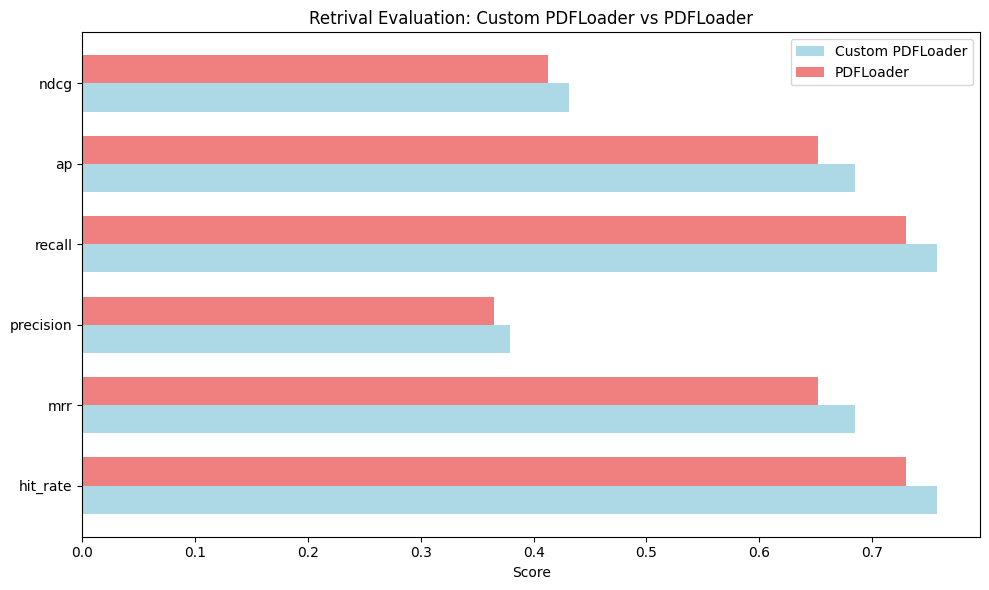

In [17]:
compare_results("Custom PDFLoader", "PDFLoader", val_results_custom, val_results_pdf, metrics,  output_path = "result.png",include_cohere_rerank=False)
